In [ ]:
import torch
from torch.nn.utils import prune
import torch.nn as nn
from tqdm import tqdm
import numpy as np
from torch.nn import CrossEntropyLoss
import torchvision.datasets as datasets
import torchvision
import torch.nn.functional as F
from matplotlib import pyplot as plt

In [ ]:
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
test_data = datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
train_data, val_data = torch.utils.data.random_split(train_data, [50000, 10000])

100%|██████████| 9912422/9912422 [00:00<00:00, 102485268.37it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 17866621.51it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25732783.38it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4765014.70it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=400,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=400,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=400,shuffle=True)

In [ ]:
class Le_Net(nn.Module):
    def __init__(self, hidden_layer1=300, hidden_layer2=100, output_layer=10):
        super(Le_Net,self).__init__()
        self.classifier = nn.Sequential(nn.Linear(784,hidden_layer1),
                                        nn.ReLU(inplace=True),
                                        nn.Linear(hidden_layer1, hidden_layer2),
                                        nn.ReLU(inplace=True),
                                        nn.Linear(hidden_layer2, output_layer))
    def forward(self, input_data):
        input_tensor = torch.flatten(input=input_data, start_dim=1)
        y = self.classifier(input_tensor)
        return y

In [ ]:
class Le_Net1(nn.Module):
    def __init__(self, hidden_layer1=300, hidden_layer2=100, output_layer=10):
        super(Le_Net1, self).__init__()

        # Randomly initialize weights for linear layers
        self.classifier = nn.Sequential(
            nn.Linear(784, hidden_layer1),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_layer1, hidden_layer2),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_layer2, output_layer)
        )

        # Initialize the weights with random values
        self.initialize_weights()

    def initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_normal_(module.weight)
                nn.init.zeros_(module.bias)

    def forward(self, input_data):
        input_tensor = torch.flatten(input=input_data, start_dim=1)
        y = self.classifier(input_tensor)
        return y


In [ ]:
def load_cifar10(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, test_loader

In [ ]:
def ERK(model, val, erk_power_scale=1.0):
    density = 1-val
    device = next(model.parameters()).device  # Get the device of the model's parameters
    total_params = 0
    for name, param in model.named_parameters():
        total_params += param.numel()
    is_epsilon_valid = False

    dense_layers = set()
    while not is_epsilon_valid:
        divisor = 0
        rhs = 0
        raw_probabilities = {}
        for name, param in model.named_parameters():
            if 'bias' in name:
                continue
            n_param = np.prod(param.shape)
            n_zeros = n_param * (1 - density)
            n_ones = n_param * density

            if name in dense_layers:
                rhs -= n_zeros
            else:
                rhs += n_ones
                raw_probabilities[name] = (np.sum(param.shape) / np.prod(param.shape)) ** erk_power_scale
                divisor += raw_probabilities[name] * n_param
        epsilon = rhs / divisor
        max_prob = np.max(list(raw_probabilities.values()))
        max_prob_one = max_prob * epsilon
        if max_prob_one > 1:
            is_epsilon_valid = False
            for param_name, param_raw_prob in raw_probabilities.items():
                if param_raw_prob == max_prob:
                    dense_layers.add(param_name)
        else:
            is_epsilon_valid = True

    density_dict = {}
    total_nonzero = 0.0
    # With the valid epsilon, we can set sparsities of the remaining layers.
    for name, param in model.named_parameters():
        if 'bias' in name:
            continue

        n_param = np.prod(param.shape)
        if name in dense_layers:
            density_dict[name] = 1.0
        else:
            probability_one = epsilon * raw_probabilities[name]
            density_dict[name] = probability_one

        # Create a new tensor with the sparsity pattern and move it to the same device as the model's parameters
        sparsity_mask = (torch.rand(param.shape, device=device) < density_dict[name]).float()

        # Replace the model's parameter with the new sparsity mask
        param.data = param.data * sparsity_mask

        total_nonzero += density_dict[name] * param.numel()
    overall_sparsity = total_nonzero / total_params
    a =  list(density_dict.values())
    for i in range(len(a)):
      a[i] = 1-a[i]
    return a


In [ ]:
def SNIP(model, val):
    keep_ratio = 1-val
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'

    model.to(device)

    # Create lists to store the weights, gradients, and scores for different layers
    weights = []
    grads = []
    scores = []
    image, label = next(iter(train_loader))
    n = image.shape[0]
    image, label = image.to(device), label.to(device)
    one_hot_label = torch.zeros((n, 10), device=device)
    for qq in range(n):
      one_hot_label[qq, label[qq]] = 1.0
    output = model(image)
    loss = criterion(output, one_hot_label)

    optimizer.zero_grad()
    loss.backward()

            # Calculate scores for each layer's weights and gradients
    i = 0
    for name, param in model.named_parameters():
      if 'weight' in name:
        weights.append(param)
        grads.append(param.grad)
        score = torch.abs(param * param.grad)
        scores.append(score)
    # Calculate the threshold for pruning based on keep_ratio
    all_scores = torch.cat([torch.flatten(x) for x in scores])
    num_params_to_keep = int(keep_ratio * len(all_scores))
    threshold, _ = torch.topk(all_scores, num_params_to_keep, sorted=True)
    ratios = []
    tc = 0
    for i, param in enumerate(weights):
        count = sum([(tensor > threshold[-1]).sum().item() for tensor in scores[i]])
        tc += count
        ratio = count/param.numel()
        ratios.append(ratio)
    final = tc/len(all_scores)

    if final > keep_ratio + 0.01 or final < keep_ratio - 0.01:
      final = 0
      ratios[0] = 1-((1-keep_ratio) * len(all_scores))/weights[0].numel()
      final += ratios[0]*weights[0].numel()
      for i in range(1,len(weights)):
        ratios[i] = 1
        final += weights[i].numel()
      final /= len(all_scores)
    print(final)
    return [1-x for x in ratios]

In [ ]:
def give_sparsity_ratios(model,ratio_type, val, h = [784,300,100,10]):
    #Need to implement other sparsity ratios.
    l = []
    if(ratio_type=="uniform"):
        l = [val]*3
    elif(ratio_type=="SNIP"):
      l = SNIP(model,val)
    elif(ratio_type=="ERK+"):
      pass
    elif(ratio_type=="uniform+"):
      l = [val]*3
      if l[-1] > 0.8:
        l[-1] = 0.8 # Last layer has atleast 20 % connections
    elif(ratio_type=="GraSP"):
      pass
    elif(ratio_type=="ERK"):
      l = ERK(model,val)

    return l

## Training

In [ ]:
def accuracy(model, loaded_data=test_loader):
    model.eval()
    device = "cpu"
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loaded_data:  # Change test_loader to loaded_data here
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the GPU if available
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test data: {accuracy:.2f}%')
    return accuracy


In [ ]:
def training(model, learning_rate,layer_wise_sparsity, ephocs):
    #model, optimizer, learning_rate,layer_wise_sparsity, ephocs):
    optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)
    criterion = CrossEntropyLoss()
    j = 0
    print("Optimizer and criterion for training success")
    for i in range(len(layer_wise_sparsity)):
        print(model.classifier[j])
        prune.random_unstructured(model.classifier[j],name='weight',amount=layer_wise_sparsity[i])
        j+=2
        print(i,j)
    print("Pruning done")
    print("Training begins")
    store_loss = []
    count = 0
    if(torch.cuda.is_available()==True):
        device = 'cuda:0'
    else:
        device = 'cpu'
    device = 'cpu'
    model = model.to(device)
    for i in tqdm(range(1,1+ephocs),total=ephocs,leave=False,desc="Epoch"):
        pbar = tqdm(leave=False)
        for index,(image,label) in enumerate(train_loader):
            count=count+1
            n = image.shape[0]
            #print(image.shape)
            image = image.view((n,28,28))
            image, label = image.to(device), label.to(device)
            one_hot_label = torch.zeros((n,10))
            for qq in range(n):
                one_hot_label[qq,label[qq]] = 1.0
            one_hot_label = one_hot_label.to(device)
            output = torch.zeros(one_hot_label.shape)
            output = output.to(device)
            output = model(image)
            optimizer.zero_grad()

            loss = criterion(output, one_hot_label)
            #print(loss.item())
            loss.backward()
            optimizer.step()
            if(count%100==0):
                #print(count, "steps done")
                store_loss.append(loss.item())
    s = "Sparsity " + str(layer_wise_sparsity[0])
    plt.plot(store_loss, label=s)
    return model

[0.0, 0.0, 0.0]
Optimizer and criterion for training success
Linear(in_features=784, out_features=300, bias=True)
0 2
Linear(in_features=300, out_features=100, bias=True)
1 4
Linear(in_features=100, out_features=10, bias=True)
2 6
Pruning done
Training begins


Epoch:  20%|██        | 1/5 [00:06<00:27,  6.82s/it]

0it [00:00, ?it/s]
Epoch:  40%|████      | 2/5 [00:14<00:22,  7.37s/it]
0it [00:00, ?it/s]

Epoch:  60%|██████    | 3/5 [00:21<00:14,  7.08s/it]

0it [00:00, ?it/s]
Epoch:  80%|████████  | 4/5 [00:29<00:07,  7.34s/it]
0it [00:00, ?it/s]

                                                    
                  

Accuracy of the model on the test data: 98.52%
98.515
Accuracy of the model on the test data: 98.52%
[0.05, 0.05, 0.05]
Optimizer and criterion for training success
Linear(in_features=784, out_features=300, bias=True)
0 2
Linear(in_features=300, out_features=100, bias=True)
1 4
Linear(in_features=100, out_features=10, bias=True)
2 6
Pruning done
Training begins


Epoch:  20%|██        | 1/5 [00:08<00:32,  8.09s/it]

0it [00:00, ?it/s]
Epoch:  40%|████      | 2/5 [00:15<00:22,  7.65s/it]
0it [00:00, ?it/s]

Epoch:  60%|██████    | 3/5 [00:22<00:15,  7.56s/it]

0it [00:00, ?it/s]
Epoch:  80%|████████  | 4/5 [00:30<00:07,  7.51s/it]
0it [00:00, ?it/s]

                                                    
                  

Accuracy of the model on the test data: 98.02%
98.01833333333333
Accuracy of the model on the test data: 98.02%
[0.1, 0.1, 0.1]
Optimizer and criterion for training success
Linear(in_features=784, out_features=300, bias=True)
0 2
Linear(in_features=300, out_features=100, bias=True)
1 4
Linear(in_features=100, out_features=10, bias=True)
2 6
Pruning done
Training begins


Epoch:  20%|██        | 1/5 [00:07<00:30,  7.73s/it]

0it [00:00, ?it/s]
Epoch:  40%|████      | 2/5 [00:14<00:21,  7.20s/it]
0it [00:00, ?it/s]

Epoch:  60%|██████    | 3/5 [00:22<00:14,  7.47s/it]

0it [00:00, ?it/s]
Epoch:  80%|████████  | 4/5 [00:29<00:07,  7.22s/it]
0it [00:00, ?it/s]

                                                    
                  

Accuracy of the model on the test data: 98.19%
98.195
Accuracy of the model on the test data: 98.19%
[0.2, 0.2, 0.2]
Optimizer and criterion for training success
Linear(in_features=784, out_features=300, bias=True)
0 2
Linear(in_features=300, out_features=100, bias=True)
1 4
Linear(in_features=100, out_features=10, bias=True)
2 6
Pruning done
Training begins


Epoch:  20%|██        | 1/5 [00:06<00:27,  6.81s/it]

0it [00:00, ?it/s]
Epoch:  40%|████      | 2/5 [00:14<00:22,  7.56s/it]
0it [00:00, ?it/s]

Epoch:  60%|██████    | 3/5 [00:21<00:14,  7.15s/it]

0it [00:00, ?it/s]
Epoch:  80%|████████  | 4/5 [00:29<00:07,  7.53s/it]
0it [00:00, ?it/s]

                                                    
                  

Accuracy of the model on the test data: 98.05%
98.045
Accuracy of the model on the test data: 98.05%
[0.3, 0.3, 0.3]
Optimizer and criterion for training success
Linear(in_features=784, out_features=300, bias=True)
0 2
Linear(in_features=300, out_features=100, bias=True)
1 4
Linear(in_features=100, out_features=10, bias=True)
2 6
Pruning done
Training begins


Epoch:  20%|██        | 1/5 [00:07<00:30,  7.54s/it]

0it [00:00, ?it/s]
Epoch:  40%|████      | 2/5 [00:15<00:23,  7.78s/it]
0it [00:00, ?it/s]

Epoch:  60%|██████    | 3/5 [00:22<00:14,  7.49s/it]

0it [00:00, ?it/s]
Epoch:  80%|████████  | 4/5 [00:30<00:07,  7.69s/it]
0it [00:00, ?it/s]

                                                    
                  

Accuracy of the model on the test data: 97.95%
97.94666666666667
Accuracy of the model on the test data: 97.95%
[0.5, 0.5, 0.5]
Optimizer and criterion for training success
Linear(in_features=784, out_features=300, bias=True)
0 2
Linear(in_features=300, out_features=100, bias=True)
1 4
Linear(in_features=100, out_features=10, bias=True)
2 6
Pruning done
Training begins


Epoch:  20%|██        | 1/5 [00:08<00:32,  8.23s/it]

0it [00:00, ?it/s]
Epoch:  40%|████      | 2/5 [00:15<00:22,  7.51s/it]
0it [00:00, ?it/s]

Epoch:  60%|██████    | 3/5 [00:23<00:15,  7.77s/it]

0it [00:00, ?it/s]
Epoch:  80%|████████  | 4/5 [00:30<00:07,  7.62s/it]
0it [00:00, ?it/s]

                                                    
                  

Accuracy of the model on the test data: 97.20%
97.19833333333334
Accuracy of the model on the test data: 97.20%
[0.7, 0.7, 0.7]
Optimizer and criterion for training success
Linear(in_features=784, out_features=300, bias=True)
0 2
Linear(in_features=300, out_features=100, bias=True)
1 4
Linear(in_features=100, out_features=10, bias=True)
2 6
Pruning done
Training begins


Epoch:  20%|██        | 1/5 [00:07<00:31,  7.82s/it]

0it [00:00, ?it/s]
Epoch:  40%|████      | 2/5 [00:15<00:22,  7.45s/it]
0it [00:00, ?it/s]

Epoch:  60%|██████    | 3/5 [00:23<00:15,  7.73s/it]

0it [00:00, ?it/s]
Epoch:  80%|████████  | 4/5 [00:29<00:07,  7.41s/it]
0it [00:00, ?it/s]

                                                    
                  

Accuracy of the model on the test data: 95.86%
95.855
Accuracy of the model on the test data: 95.86%
[0.8, 0.8, 0.8]
Optimizer and criterion for training success
Linear(in_features=784, out_features=300, bias=True)
0 2
Linear(in_features=300, out_features=100, bias=True)
1 4
Linear(in_features=100, out_features=10, bias=True)
2 6
Pruning done
Training begins


Epoch:  20%|██        | 1/5 [00:06<00:27,  6.96s/it]

0it [00:00, ?it/s]
Epoch:  40%|████      | 2/5 [00:15<00:23,  7.68s/it]
0it [00:00, ?it/s]

Epoch:  60%|██████    | 3/5 [00:22<00:14,  7.34s/it]

0it [00:00, ?it/s]
Epoch:  80%|████████  | 4/5 [00:30<00:07,  7.73s/it]
0it [00:00, ?it/s]

                                                    
                  

Accuracy of the model on the test data: 94.33%
94.335
Accuracy of the model on the test data: 94.33%
[0.9, 0.9, 0.9]
Optimizer and criterion for training success
Linear(in_features=784, out_features=300, bias=True)
0 2
Linear(in_features=300, out_features=100, bias=True)
1 4
Linear(in_features=100, out_features=10, bias=True)
2 6
Pruning done
Training begins


Epoch:  20%|██        | 1/5 [00:07<00:30,  7.72s/it]

0it [00:00, ?it/s]
Epoch:  40%|████      | 2/5 [00:15<00:24,  8.00s/it]
0it [00:00, ?it/s]

Epoch:  60%|██████    | 3/5 [00:23<00:15,  7.69s/it]

0it [00:00, ?it/s]
Epoch:  80%|████████  | 4/5 [00:31<00:07,  7.89s/it]
0it [00:00, ?it/s]

                                                    
                  

Accuracy of the model on the test data: 92.78%
92.77833333333334
Accuracy of the model on the test data: 92.78%
[0.95, 0.95, 0.95]
Optimizer and criterion for training success
Linear(in_features=784, out_features=300, bias=True)
0 2
Linear(in_features=300, out_features=100, bias=True)
1 4
Linear(in_features=100, out_features=10, bias=True)
2 6
Pruning done
Training begins


Epoch:  20%|██        | 1/5 [00:08<00:34,  8.54s/it]

0it [00:00, ?it/s]
Epoch:  40%|████      | 2/5 [00:16<00:25,  8.45s/it]
0it [00:00, ?it/s]

Epoch:  60%|██████    | 3/5 [00:24<00:16,  8.02s/it]

0it [00:00, ?it/s]
Epoch:  80%|████████  | 4/5 [00:32<00:08,  8.04s/it]
0it [00:00, ?it/s]

                                                    
                  

Accuracy of the model on the test data: 90.58%
90.58333333333333
Accuracy of the model on the test data: 90.58%
[0.99, 0.99, 0.99]
Optimizer and criterion for training success
Linear(in_features=784, out_features=300, bias=True)
0 2
Linear(in_features=300, out_features=100, bias=True)
1 4
Linear(in_features=100, out_features=10, bias=True)
2 6
Pruning done
Training begins


Epoch:  20%|██        | 1/5 [00:08<00:32,  8.05s/it]

0it [00:00, ?it/s]
Epoch:  40%|████      | 2/5 [00:14<00:22,  7.40s/it]
0it [00:00, ?it/s]

Epoch:  60%|██████    | 3/5 [00:23<00:15,  7.76s/it]

0it [00:00, ?it/s]
Epoch:  80%|████████  | 4/5 [00:30<00:07,  7.41s/it]
0it [00:00, ?it/s]

                                                    
                  

Accuracy of the model on the test data: 26.32%
26.321666666666665
Accuracy of the model on the test data: 26.32%


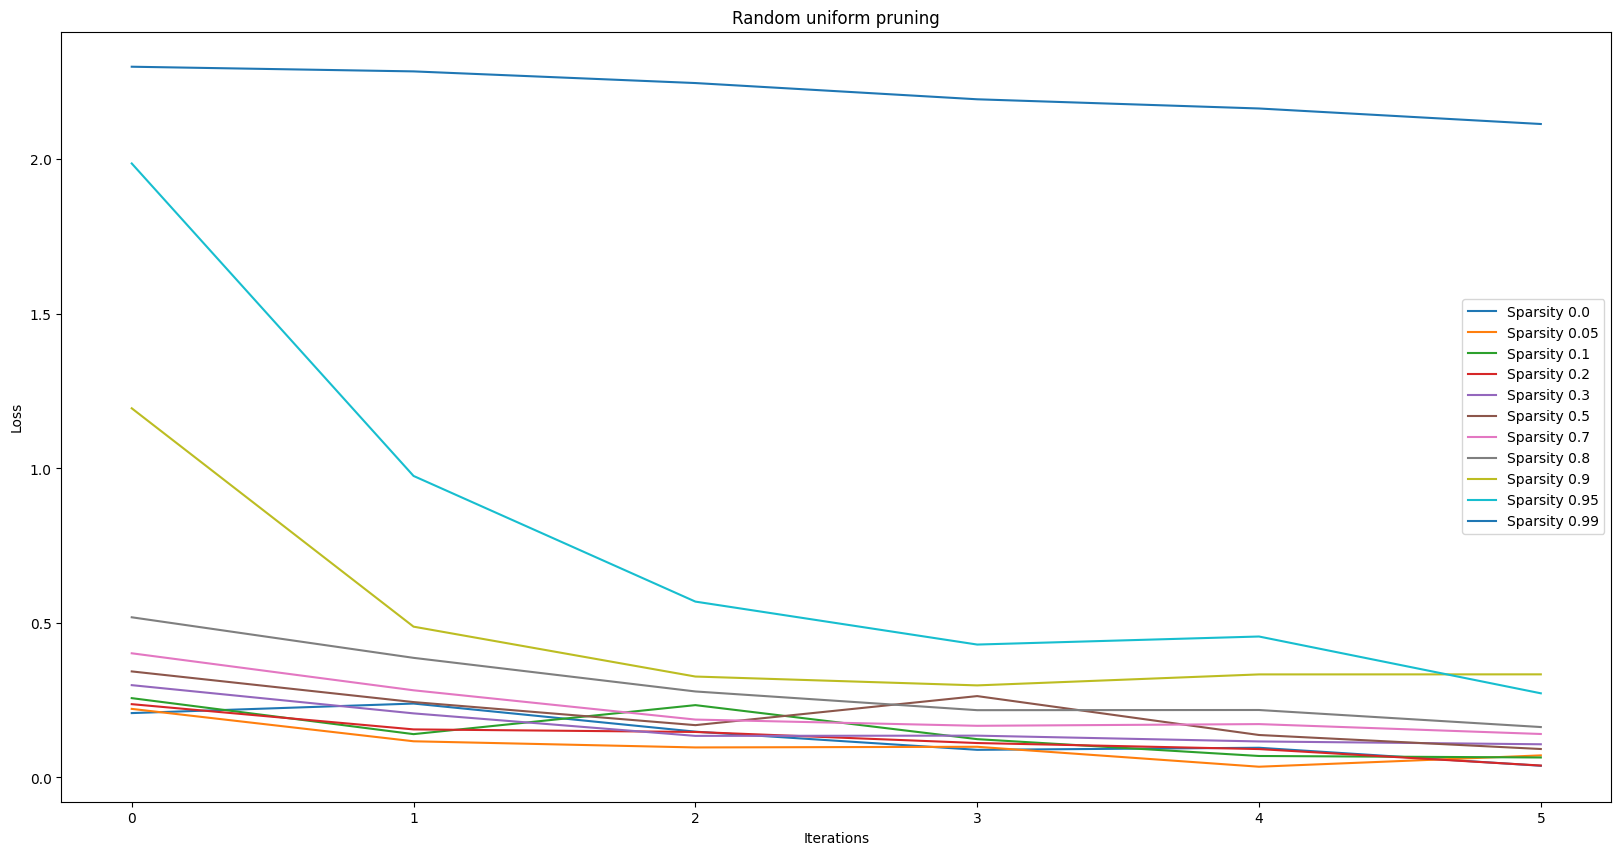

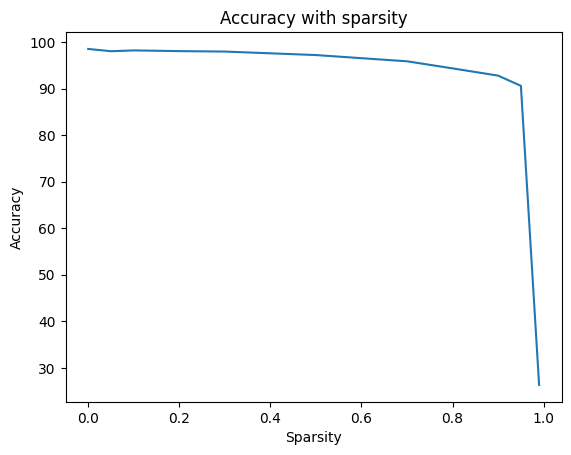

[0.0, 0.0, 0.0]
Optimizer and criterion for training success
Linear(in_features=784, out_features=300, bias=True)
0 2
Linear(in_features=300, out_features=100, bias=True)
1 4
Linear(in_features=100, out_features=10, bias=True)
2 6
Pruning done
Training begins


Epoch:  20%|██        | 1/5 [00:07<00:28,  7.02s/it]

0it [00:00, ?it/s]
Epoch:  40%|████      | 2/5 [00:14<00:21,  7.31s/it]
0it [00:00, ?it/s]

Epoch:  60%|██████    | 3/5 [00:21<00:14,  7.35s/it]

0it [00:00, ?it/s]
Epoch:  80%|████████  | 4/5 [00:29<00:07,  7.36s/it]
0it [00:00, ?it/s]

                                                    
                  

Accuracy of the model on the test data: 98.66%
98.655
Accuracy of the model on the test data: 98.66%
[0.05659013605442176, 0.0, 0.0]
Optimizer and criterion for training success
Linear(in_features=784, out_features=300, bias=True)
0 2
Linear(in_features=300, out_features=100, bias=True)
1 4
Linear(in_features=100, out_features=10, bias=True)
2 6
Pruning done
Training begins


Epoch:  20%|██        | 1/5 [00:07<00:28,  7.02s/it]

0it [00:00, ?it/s]
Epoch:  40%|████      | 2/5 [00:14<00:22,  7.58s/it]
0it [00:00, ?it/s]

Epoch:  60%|██████    | 3/5 [00:21<00:14,  7.23s/it]

0it [00:00, ?it/s]
Epoch:  80%|████████  | 4/5 [00:29<00:07,  7.52s/it]
0it [00:00, ?it/s]

                                                    
                  

Accuracy of the model on the test data: 98.31%
98.31166666666667
Accuracy of the model on the test data: 98.31%
[0.1131802721088434, 0.0, 0.0]
Optimizer and criterion for training success
Linear(in_features=784, out_features=300, bias=True)
0 2
Linear(in_features=300, out_features=100, bias=True)
1 4
Linear(in_features=100, out_features=10, bias=True)
2 6
Pruning done
Training begins


Epoch:  20%|██        | 1/5 [00:08<00:33,  8.46s/it]

0it [00:00, ?it/s]
Epoch:  40%|████      | 2/5 [00:15<00:23,  7.88s/it]
0it [00:00, ?it/s]

Epoch:  60%|██████    | 3/5 [00:23<00:15,  7.81s/it]

0it [00:00, ?it/s]
Epoch:  80%|████████  | 4/5 [00:31<00:07,  7.87s/it]
0it [00:00, ?it/s]

                                                    
                  

Accuracy of the model on the test data: 98.31%
98.315
Accuracy of the model on the test data: 98.31%
[0.22636054421768703, 0.0, 0.0]
Optimizer and criterion for training success
Linear(in_features=784, out_features=300, bias=True)
0 2
Linear(in_features=300, out_features=100, bias=True)
1 4
Linear(in_features=100, out_features=10, bias=True)
2 6
Pruning done
Training begins


Epoch:  20%|██        | 1/5 [00:08<00:33,  8.31s/it]

0it [00:00, ?it/s]
Epoch:  40%|████      | 2/5 [00:15<00:22,  7.65s/it]
0it [00:00, ?it/s]

Epoch:  60%|██████    | 3/5 [00:23<00:15,  7.96s/it]

0it [00:00, ?it/s]
Epoch:  80%|████████  | 4/5 [00:31<00:07,  7.66s/it]
0it [00:00, ?it/s]

                                                    
                  

Accuracy of the model on the test data: 98.03%
98.035
Accuracy of the model on the test data: 98.03%
[0.33954081632653066, 0.0, 0.0]
Optimizer and criterion for training success
Linear(in_features=784, out_features=300, bias=True)
0 2
Linear(in_features=300, out_features=100, bias=True)
1 4
Linear(in_features=100, out_features=10, bias=True)
2 6
Pruning done
Training begins


Epoch:  20%|██        | 1/5 [00:07<00:29,  7.46s/it]

0it [00:00, ?it/s]
Epoch:  40%|████      | 2/5 [00:15<00:23,  7.76s/it]
0it [00:00, ?it/s]

Epoch:  60%|██████    | 3/5 [00:23<00:15,  7.95s/it]

0it [00:00, ?it/s]
Epoch:  80%|████████  | 4/5 [00:30<00:07,  7.73s/it]
0it [00:00, ?it/s]

                                                    
                  

Accuracy of the model on the test data: 97.80%
97.80166666666666
Accuracy of the model on the test data: 97.80%
[0.5659013605442176, 0.0, 0.0]
Optimizer and criterion for training success
Linear(in_features=784, out_features=300, bias=True)
0 2
Linear(in_features=300, out_features=100, bias=True)
1 4
Linear(in_features=100, out_features=10, bias=True)
2 6
Pruning done
Training begins


Epoch:  20%|██        | 1/5 [00:07<00:28,  7.13s/it]

0it [00:00, ?it/s]
Epoch:  40%|████      | 2/5 [00:15<00:23,  7.89s/it]
0it [00:00, ?it/s]

Epoch:  60%|██████    | 3/5 [00:23<00:15,  7.69s/it]

0it [00:00, ?it/s]
Epoch:  80%|████████  | 4/5 [00:31<00:07,  7.93s/it]
0it [00:00, ?it/s]

                                                    
                  

Accuracy of the model on the test data: 97.41%
97.40833333333333
Accuracy of the model on the test data: 97.41%
[0.755085309056237, 0.2914645103324347, 0.0]
Optimizer and criterion for training success
Linear(in_features=784, out_features=300, bias=True)
0 2
Linear(in_features=300, out_features=100, bias=True)
1 4
Linear(in_features=100, out_features=10, bias=True)
2 6
Pruning done
Training begins


Epoch:  20%|██        | 1/5 [00:07<00:29,  7.30s/it]

0it [00:00, ?it/s]
Epoch:  40%|████      | 2/5 [00:15<00:23,  7.90s/it]
0it [00:00, ?it/s]

Epoch:  60%|██████    | 3/5 [00:22<00:15,  7.56s/it]

0it [00:00, ?it/s]
Epoch:  80%|████████  | 4/5 [00:31<00:07,  7.90s/it]
0it [00:00, ?it/s]

                                                    
                  

Accuracy of the model on the test data: 96.53%
96.53333333333333
Accuracy of the model on the test data: 96.53%
[0.8377587692759044, 0.5306379155435759, 0.0]
Optimizer and criterion for training success
Linear(in_features=784, out_features=300, bias=True)
0 2
Linear(in_features=300, out_features=100, bias=True)
1 4
Linear(in_features=100, out_features=10, bias=True)
2 6
Pruning done
Training begins


Epoch:  20%|██        | 1/5 [00:07<00:29,  7.46s/it]

0it [00:00, ?it/s]
Epoch:  40%|████      | 2/5 [00:15<00:23,  8.00s/it]
0it [00:00, ?it/s]

Epoch:  60%|██████    | 3/5 [00:23<00:15,  7.65s/it]

0it [00:00, ?it/s]
Epoch:  80%|████████  | 4/5 [00:31<00:07,  7.97s/it]
0it [00:00, ?it/s]

                                                    
                  

Accuracy of the model on the test data: 95.52%
95.52166666666666
Accuracy of the model on the test data: 95.52%
[0.9204322294955718, 0.769811320754717, 0.0]
Optimizer and criterion for training success
Linear(in_features=784, out_features=300, bias=True)
0 2
Linear(in_features=300, out_features=100, bias=True)
1 4
Linear(in_features=100, out_features=10, bias=True)
2 6
Pruning done
Training begins


Epoch:  20%|██        | 1/5 [00:08<00:32,  8.09s/it]

0it [00:00, ?it/s]
Epoch:  40%|████      | 2/5 [00:16<00:24,  8.29s/it]
0it [00:00, ?it/s]

Epoch:  60%|██████    | 3/5 [00:23<00:15,  7.82s/it]

0it [00:00, ?it/s]
Epoch:  80%|████████  | 4/5 [00:32<00:08,  8.10s/it]
0it [00:00, ?it/s]

                                                    
                  

Accuracy of the model on the test data: 93.53%
93.53333333333333
Accuracy of the model on the test data: 93.53%
[0.9615158673256002, 0.8886658301965703, 0.08149309912170544]
Optimizer and criterion for training success
Linear(in_features=784, out_features=300, bias=True)
0 2
Linear(in_features=300, out_features=100, bias=True)
1 4
Linear(in_features=100, out_features=10, bias=True)
2 6
Pruning done
Training begins


Epoch:  20%|██        | 1/5 [00:08<00:33,  8.29s/it]

0it [00:00, ?it/s]
Epoch:  40%|████      | 2/5 [00:16<00:24,  8.05s/it]
0it [00:00, ?it/s]

Epoch:  60%|██████    | 3/5 [00:23<00:15,  7.90s/it]

0it [00:00, ?it/s]
Epoch:  80%|████████  | 4/5 [00:32<00:08,  8.08s/it]
0it [00:00, ?it/s]

                                                    
                  

Accuracy of the model on the test data: 89.78%
89.78333333333333
Accuracy of the model on the test data: 89.78%
[0.9923031734651201, 0.977733166039314, 0.8162986198243412]
Optimizer and criterion for training success
Linear(in_features=784, out_features=300, bias=True)
0 2
Linear(in_features=300, out_features=100, bias=True)
1 4
Linear(in_features=100, out_features=10, bias=True)
2 6
Pruning done
Training begins


Epoch:  20%|██        | 1/5 [00:08<00:34,  8.64s/it]

0it [00:00, ?it/s]
Epoch:  40%|████      | 2/5 [00:15<00:23,  7.81s/it]
0it [00:00, ?it/s]

Epoch:  60%|██████    | 3/5 [00:24<00:16,  8.05s/it]

0it [00:00, ?it/s]
Epoch:  80%|████████  | 4/5 [00:32<00:08,  8.06s/it]
0it [00:00, ?it/s]

                                                    
                  

Accuracy of the model on the test data: 11.24%
11.236666666666666
Accuracy of the model on the test data: 11.24%


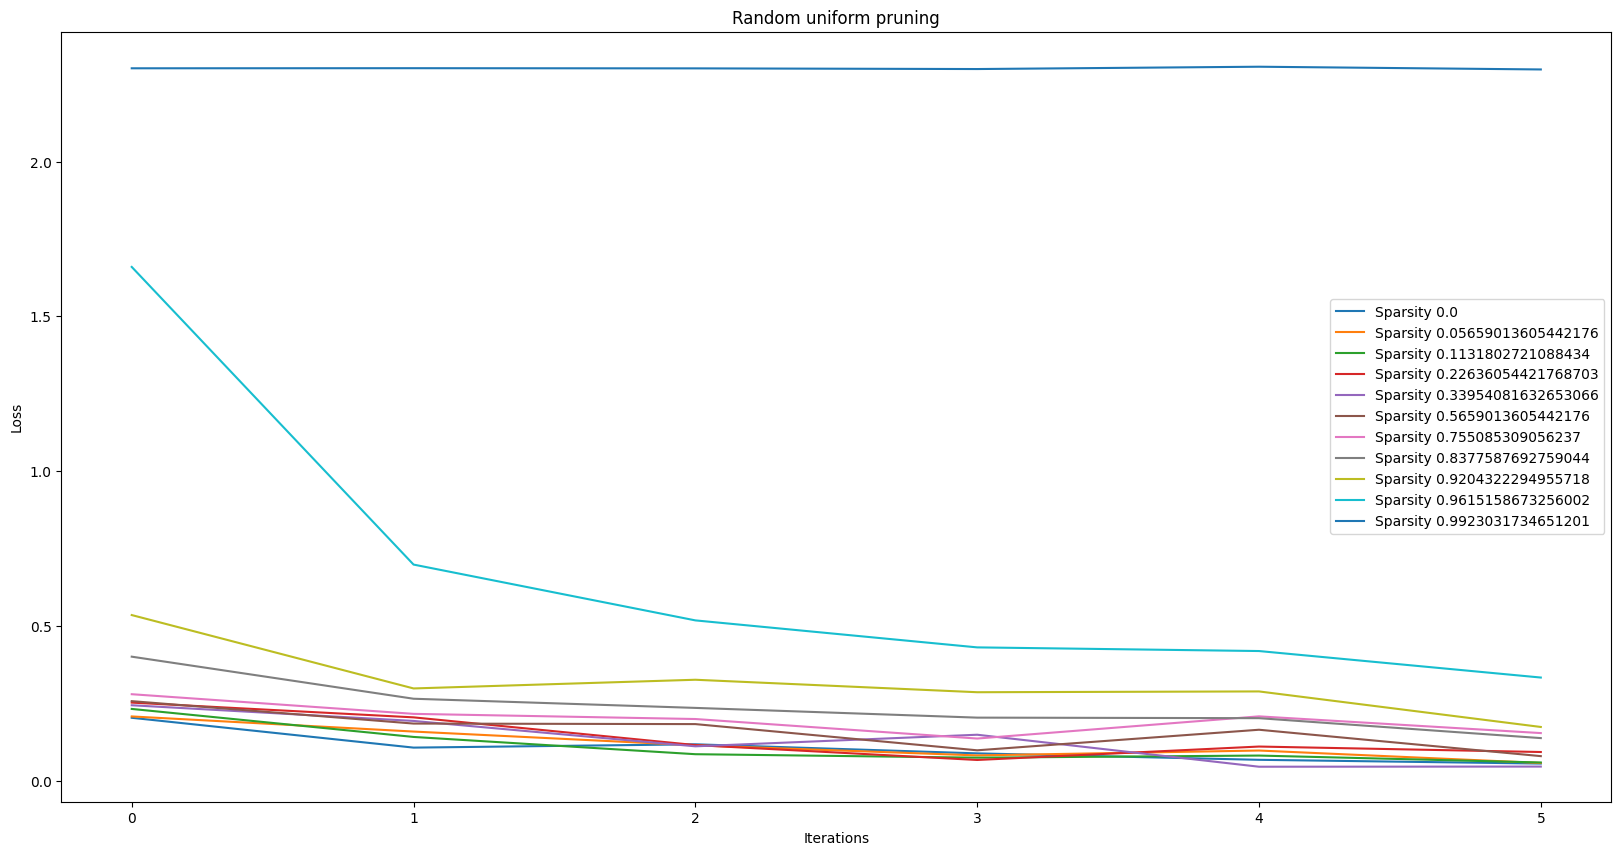

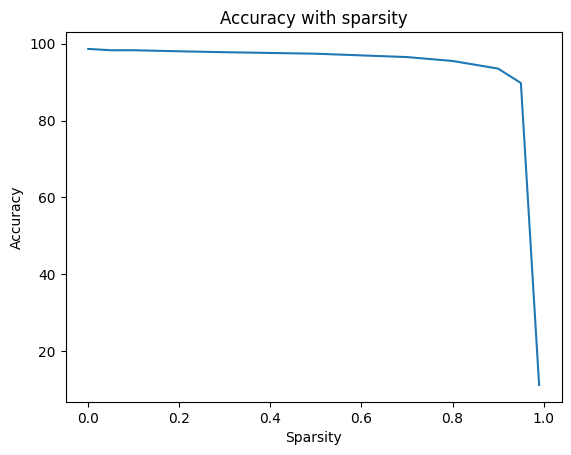

1.0
[0.0, 0, 0]
Optimizer and criterion for training success
Linear(in_features=784, out_features=300, bias=True)
0 2
Linear(in_features=300, out_features=100, bias=True)
1 4
Linear(in_features=100, out_features=10, bias=True)
2 6
Pruning done
Training begins


Epoch:  20%|██        | 1/5 [00:07<00:29,  7.28s/it]

0it [00:00, ?it/s]
Epoch:  40%|████      | 2/5 [00:15<00:22,  7.59s/it]
0it [00:00, ?it/s]

Epoch:  60%|██████    | 3/5 [00:22<00:15,  7.50s/it]

0it [00:00, ?it/s]
Epoch:  80%|████████  | 4/5 [00:29<00:07,  7.45s/it]
0it [00:00, ?it/s]

                                                    
                  

Accuracy of the model on the test data: 98.62%
98.62333333333333
Accuracy of the model on the test data: 98.62%
0.9499999999999998
[0.05659013605442187, 0, 0]
Optimizer and criterion for training success
Linear(in_features=784, out_features=300, bias=True)
0 2
Linear(in_features=300, out_features=100, bias=True)
1 4
Linear(in_features=100, out_features=10, bias=True)
2 6
Pruning done
Training begins


Epoch:  20%|██        | 1/5 [00:07<00:28,  7.01s/it]

0it [00:00, ?it/s]
Epoch:  40%|████      | 2/5 [00:15<00:23,  7.67s/it]
0it [00:00, ?it/s]

Epoch:  60%|██████    | 3/5 [00:22<00:14,  7.47s/it]

0it [00:00, ?it/s]
Epoch:  80%|████████  | 4/5 [00:30<00:07,  7.77s/it]
0it [00:00, ?it/s]

                                                    
                  

Accuracy of the model on the test data: 98.05%
98.05166666666666
Accuracy of the model on the test data: 98.05%
0.9
[0.11318027210884352, 0, 0]
Optimizer and criterion for training success
Linear(in_features=784, out_features=300, bias=True)
0 2
Linear(in_features=300, out_features=100, bias=True)
1 4
Linear(in_features=100, out_features=10, bias=True)
2 6
Pruning done
Training begins


Epoch:  20%|██        | 1/5 [00:07<00:31,  7.78s/it]

0it [00:00, ?it/s]
Epoch:  40%|████      | 2/5 [00:15<00:23,  7.79s/it]
0it [00:00, ?it/s]

Epoch:  60%|██████    | 3/5 [00:22<00:15,  7.59s/it]

0it [00:00, ?it/s]
Epoch:  80%|████████  | 4/5 [00:30<00:07,  7.74s/it]
0it [00:00, ?it/s]

                                                    
                  

Accuracy of the model on the test data: 98.04%
98.04166666666667
Accuracy of the model on the test data: 98.04%
0.8
[0.22636054421768703, 0, 0]
Optimizer and criterion for training success
Linear(in_features=784, out_features=300, bias=True)
0 2
Linear(in_features=300, out_features=100, bias=True)
1 4
Linear(in_features=100, out_features=10, bias=True)
2 6
Pruning done
Training begins


Epoch:  20%|██        | 1/5 [00:09<00:38,  9.51s/it]

0it [00:00, ?it/s]
Epoch:  40%|████      | 2/5 [00:16<00:24,  8.03s/it]
0it [00:00, ?it/s]

Epoch:  60%|██████    | 3/5 [00:24<00:16,  8.11s/it]

0it [00:00, ?it/s]
Epoch:  80%|████████  | 4/5 [00:32<00:07,  7.84s/it]
0it [00:00, ?it/s]

                                                    
                  

Accuracy of the model on the test data: 98.22%
98.21833333333333
Accuracy of the model on the test data: 98.22%
0.6999962434259955
[0.3376785714285714, 0.014633333333333387, 0.0]
Optimizer and criterion for training success
Linear(in_features=784, out_features=300, bias=True)
0 2
Linear(in_features=300, out_features=100, bias=True)
1 4
Linear(in_features=100, out_features=10, bias=True)
2 6
Pruning done
Training begins


Epoch:  20%|██        | 1/5 [00:08<00:32,  8.21s/it]

0it [00:00, ?it/s]
Epoch:  40%|████      | 2/5 [00:15<00:22,  7.59s/it]
0it [00:00, ?it/s]

Epoch:  60%|██████    | 3/5 [00:23<00:15,  7.86s/it]

0it [00:00, ?it/s]
Epoch:  80%|████████  | 4/5 [00:30<00:07,  7.59s/it]
0it [00:00, ?it/s]

                                                    
                  

Accuracy of the model on the test data: 98.24%
98.23833333333333
Accuracy of the model on the test data: 98.24%
0.49999624342599547
[0.5396598639455783, 0.20333333333333337, 0.07299999999999995]
Optimizer and criterion for training success
Linear(in_features=784, out_features=300, bias=True)
0 2
Linear(in_features=300, out_features=100, bias=True)
1 4
Linear(in_features=100, out_features=10, bias=True)
2 6
Pruning done
Training begins


Epoch:  20%|██        | 1/5 [00:07<00:30,  7.58s/it]

0it [00:00, ?it/s]
Epoch:  40%|████      | 2/5 [00:15<00:23,  7.88s/it]
0it [00:00, ?it/s]

Epoch:  60%|██████    | 3/5 [00:23<00:16,  8.03s/it]

0it [00:00, ?it/s]
Epoch:  80%|████████  | 4/5 [00:31<00:07,  7.82s/it]
0it [00:00, ?it/s]

                                                    
                  

Accuracy of the model on the test data: 97.47%
97.46833333333333
Accuracy of the model on the test data: 97.47%
0.2999962434259955
[0.7370025510204081, 0.4281666666666667, 0.15300000000000002]
Optimizer and criterion for training success
Linear(in_features=784, out_features=300, bias=True)
0 2
Linear(in_features=300, out_features=100, bias=True)
1 4
Linear(in_features=100, out_features=10, bias=True)
2 6
Pruning done
Training begins


Epoch:  20%|██        | 1/5 [00:07<00:28,  7.08s/it]

0it [00:00, ?it/s]
Epoch:  40%|████      | 2/5 [00:15<00:23,  7.88s/it]
0it [00:00, ?it/s]

Epoch:  60%|██████    | 3/5 [00:22<00:15,  7.64s/it]

0it [00:00, ?it/s]
Epoch:  80%|████████  | 4/5 [00:30<00:07,  7.77s/it]
0it [00:00, ?it/s]

                                                    
                  

Accuracy of the model on the test data: 96.78%
96.785
Accuracy of the model on the test data: 96.78%
0.19999248685199097
[0.8283248299319728, 0.5958333333333333, 0.265]
Optimizer and criterion for training success
Linear(in_features=784, out_features=300, bias=True)
0 2
Linear(in_features=300, out_features=100, bias=True)
1 4
Linear(in_features=100, out_features=10, bias=True)
2 6
Pruning done
Training begins


Epoch:  20%|██        | 1/5 [00:07<00:29,  7.46s/it]

0it [00:00, ?it/s]
Epoch:  40%|████      | 2/5 [00:15<00:23,  7.89s/it]
0it [00:00, ?it/s]

Epoch:  60%|██████    | 3/5 [00:22<00:15,  7.54s/it]

0it [00:00, ?it/s]
Epoch:  80%|████████  | 4/5 [00:31<00:07,  7.87s/it]
0it [00:00, ?it/s]

                                                    
                  

Accuracy of the model on the test data: 95.52%
95.52333333333333
Accuracy of the model on the test data: 95.52%
0.09999248685199098
[0.9225, 0.7413666666666667, 0.369]
Optimizer and criterion for training success
Linear(in_features=784, out_features=300, bias=True)
0 2
Linear(in_features=300, out_features=100, bias=True)
1 4
Linear(in_features=100, out_features=10, bias=True)
2 6
Pruning done
Training begins


Epoch:  20%|██        | 1/5 [00:08<00:33,  8.42s/it]

0it [00:00, ?it/s]
Epoch:  40%|████      | 2/5 [00:16<00:23,  7.98s/it]
0it [00:00, ?it/s]

Epoch:  60%|██████    | 3/5 [00:24<00:16,  8.16s/it]

0it [00:00, ?it/s]
Epoch:  80%|████████  | 4/5 [00:33<00:08,  8.41s/it]
0it [00:00, ?it/s]

                                                    
                  

Accuracy of the model on the test data: 94.16%
94.155
Accuracy of the model on the test data: 94.16%
0.04999624342599549
[0.9647236394557823, 0.8506, 0.47]
Optimizer and criterion for training success
Linear(in_features=784, out_features=300, bias=True)
0 2
Linear(in_features=300, out_features=100, bias=True)
1 4
Linear(in_features=100, out_features=10, bias=True)
2 6
Pruning done
Training begins


Epoch:  20%|██        | 1/5 [00:08<00:32,  8.12s/it]

0it [00:00, ?it/s]
Epoch:  40%|████      | 2/5 [00:15<00:23,  7.69s/it]
0it [00:00, ?it/s]

Epoch:  60%|██████    | 3/5 [00:23<00:15,  7.75s/it]

0it [00:00, ?it/s]
Epoch:  80%|████████  | 4/5 [00:31<00:07,  7.84s/it]
0it [00:00, ?it/s]

                                                    
                  

Accuracy of the model on the test data: 92.40%
92.40166666666667
Accuracy of the model on the test data: 92.40%
0.009996243425995492
[0.9953061224489796, 0.9581, 0.7]
Optimizer and criterion for training success
Linear(in_features=784, out_features=300, bias=True)
0 2
Linear(in_features=300, out_features=100, bias=True)
1 4
Linear(in_features=100, out_features=10, bias=True)
2 6
Pruning done
Training begins


Epoch:  20%|██        | 1/5 [00:08<00:32,  8.11s/it]

0it [00:00, ?it/s]
Epoch:  40%|████      | 2/5 [00:15<00:22,  7.43s/it]
0it [00:00, ?it/s]

Epoch:  60%|██████    | 3/5 [00:23<00:15,  7.86s/it]

0it [00:00, ?it/s]
Epoch:  80%|████████  | 4/5 [00:30<00:07,  7.50s/it]
0it [00:00, ?it/s]

                                                    
                  

Accuracy of the model on the test data: 83.33%
83.335
Accuracy of the model on the test data: 83.33%


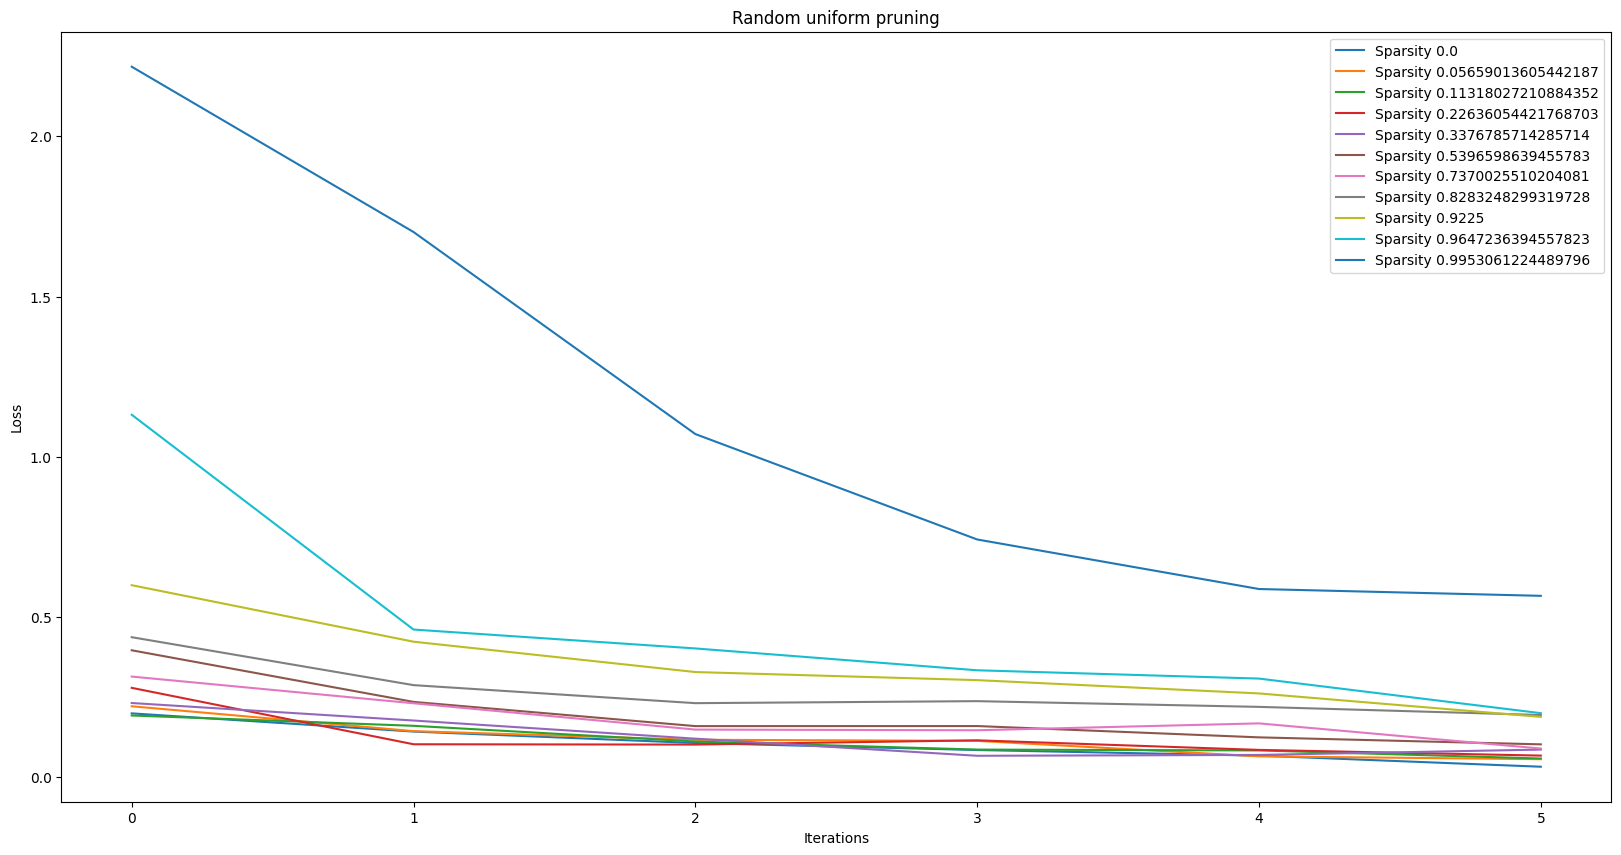

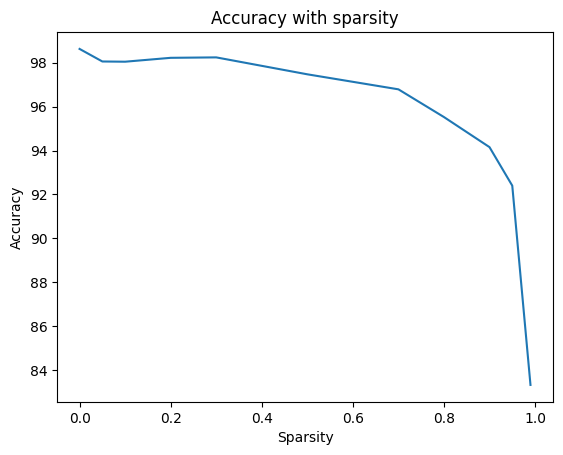

In [ ]:
tmod = []
accurac = []
for k in ["uniform","ERK","SNIP"]:
  learning_rate = 0.001
  val = [0.0, 0.05,0.10,0.20,0.30,0.50,0.70,0.80,0.90,0.95,0.99]
  ephocs = 5
  models = []
  acc = []
  plt.figure(figsize=(20,10))
  for sparsity in val:
      model = Le_Net1()
      layer_wise_sparsity = give_sparsity_ratios(model,k,sparsity)
      print(layer_wise_sparsity)
      model_test = training(model, learning_rate,layer_wise_sparsity, ephocs )
      models.append(model_test)
      print(accuracy(model_test))
      acc.append(accuracy(model_test))
  accurac.append(acc)
  tmod.append(models)
  plt.legend()
  plt.title("Random uniform pruning")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()
  plt.plot(val,acc)
  plt.title("Accuracy with sparsity")
  plt.ylabel("Accuracy")
  plt.xlabel("Sparsity")
  plt.show()


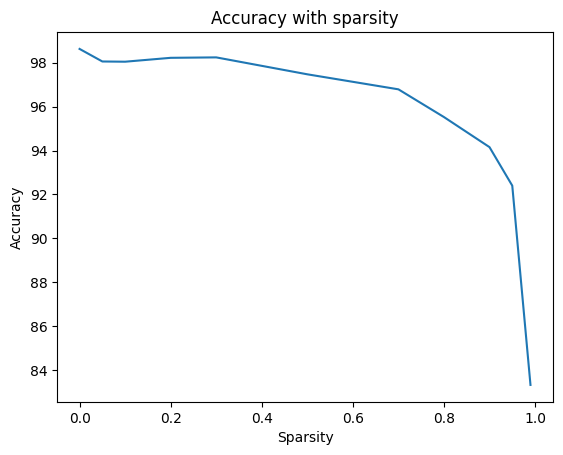

In [ ]:
plt.plot(val,acc)
plt.title("Accuracy with sparsity")
plt.ylabel("Accuracy")
plt.xlabel("Sparsity")
plt.show()

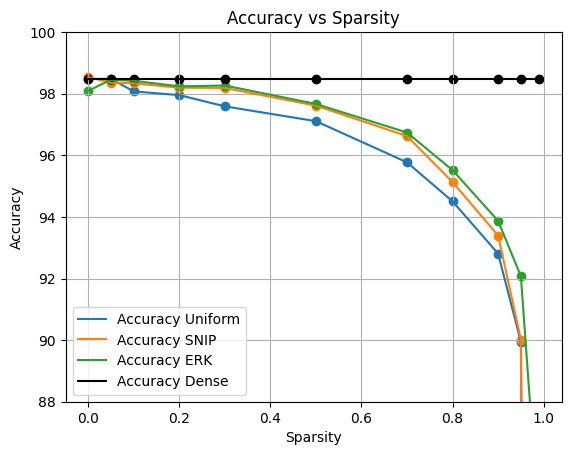

In [ ]:
a = ["Uniform","SNIP","ERK","Dense"]
for i in range(len(accurac)):
    plt.plot(val, accurac[i], label=f'Accuracy {a[i]}')
    plt.scatter(val, accurac[i], marker='o')
plt.plot(val, ab,'k' ,label=f'Accuracy {a[3]}')
plt.scatter(val, ab,c='black', marker='o')
plt.xlabel('Sparsity')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Sparsity')
plt.ylim(88, 100)
plt.grid(True)
plt.legend()
plt.show()

[0.0, 0.0, 0.0]
Optimizer and criterion for training success
Linear(in_features=784, out_features=300, bias=True)
0 2
Linear(in_features=300, out_features=100, bias=True)
1 4
Linear(in_features=100, out_features=10, bias=True)
2 6
Pruning done
Training begins


Epoch:  20%|██        | 1/5 [00:07<00:30,  7.74s/it]

0it [00:00, ?it/s]
Epoch:  40%|████      | 2/5 [00:14<00:21,  7.33s/it]
0it [00:00, ?it/s]

Epoch:  60%|██████    | 3/5 [00:22<00:15,  7.52s/it]

0it [00:00, ?it/s]
Epoch:  80%|████████  | 4/5 [00:29<00:07,  7.25s/it]
0it [00:00, ?it/s]

                                                    
                  

Accuracy of the model on the test data: 98.59%
98.59
Accuracy of the model on the test data: 98.59%


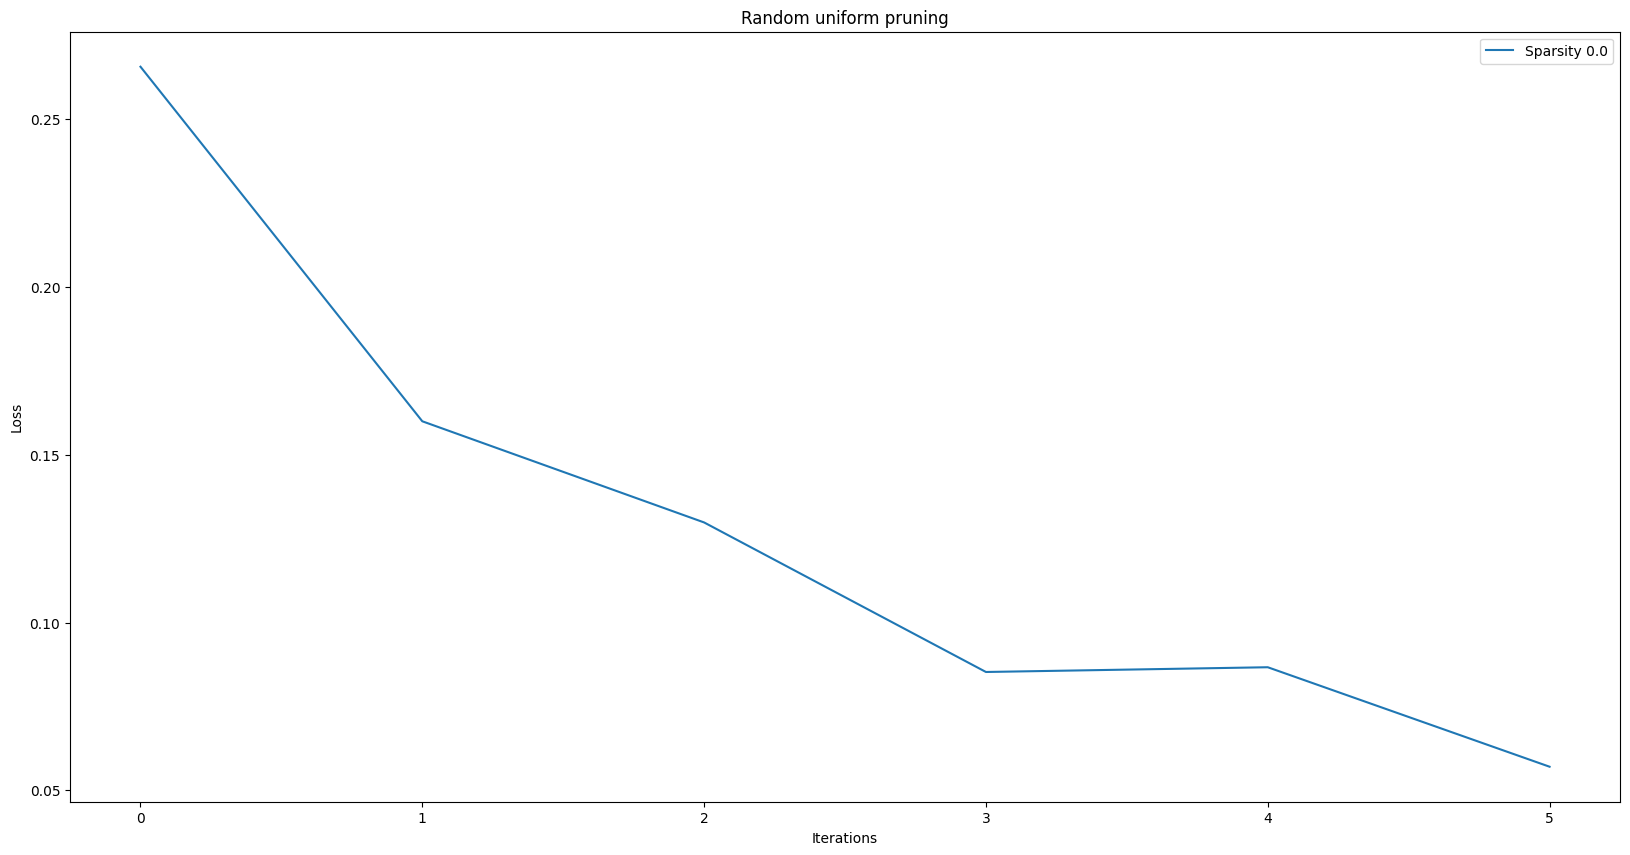

ValueError: ignored

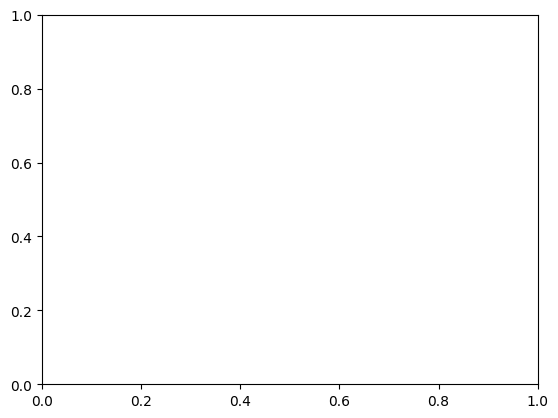

In [ ]:
tmod = []
accu = []
for k in ["uniform"]:
  learning_rate = 0.001
  valu = [0.0]
  ephocs = 5
  models = []
  acc = []
  plt.figure(figsize=(20,10))
  for sparsity in valu:
      model = Le_Net1()
      layer_wise_sparsity = give_sparsity_ratios(model,k,sparsity)
      print(layer_wise_sparsity)
      model_test = training(model, learning_rate,layer_wise_sparsity, ephocs )
      models.append(model_test)
      print(accuracy(model_test))
      acc.append(accuracy(model_test))
  accu.append(acc)
  tmod.append(models)
  plt.legend()
  plt.title("Random uniform pruning")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()
  plt.plot(val,acc)
  plt.title("Accuracy with sparsity")
  plt.ylabel("Accuracy")
  plt.xlabel("Sparsity")
  plt.show()
